## **Support Vector Machine (SVM) - Final Model & Results**

### **Overview**

This notebook presents the **Support Vector Machine (SVM) model** for classification. The model is trained using **optimized hyperparameters**, **5-Fold Cross-Validation**, and various **evaluation metrics** to ensure robust generalization performance.

---

### **Data Preprocessing & Preparation**

- **Dataset**: `final_dataset.csv`
- **Label Encoding**: Converts categorical labels into numerical format.
- **Feature Scaling**: Uses **`StandardScaler()`** inside a **Pipeline** to ensure proper normalization.
- **Stratified Train-Test Split**: Ensures class balance in training and testing sets.
- **SMOTETomek Applied**: Handles class imbalance before training.

---

### **SVM Model & Best Hyperparameters**

The **SVM model** was optimized through **Grid Search / Random Search Cross-Validation**, yielding the best hyperparameters:

| Hyperparameter                   | Selected Value      |
| -------------------------------- | ------------------- |
| **Kernel**                       | Polynomial (`poly`) |
| **C (Regularization Parameter)** | **100**             |
| **Degree (for poly kernel)**     | **4**               |
| **Gamma (Kernel Coefficient)**   | **0.1**             |
| **Coef0**                        | **1.0**             |
| **Probability Estimation**       | **Enabled**         |

These hyperparameters ensure **optimal decision boundaries** and prevent overfitting.

---

### **Cross-Validation Results**

The model was evaluated using **5-Fold Stratified Cross-Validation** to test performance across different data splits.

✅ **Mean Cross-Validation Accuracy:** **0.9265%**

---

### **Final Model Evaluation**

After training on the full dataset, the model was evaluated on the test set.

| Metric             | Value        |
| ------------------ | ------------ |
| **Test Accuracy**  | **0.9448%**  |
| **Train Accuracy** | **X0.9955%** |
| **Test F1-Score**  | **X0.9424**  |
| **Test Precision** | **0.9470**   |
| **Test Recall**    | **0.9448**   |



Stratified K-Fold Cross-Validation Results:
CV Scores: [0.92989466 0.92953142 0.92262986 0.92732558 0.92332849]
Mean CV Score: 0.9265
Standard Deviation of CV Scores: 0.0030

Final Model Results on Test Set:
Test Accuracy: 0.9448
Test Precision: 0.9470
Test Recall: 0.9448
Test F1-score: 0.9424
Train Accuracy: 0.9955

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.81      1.00      0.89        21
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        22
           4       0.91      1.00      0.95        21
           5       0.91      1.00      0.95        21
           6       0.95      1.00      0.98        20
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        22
           9       0.96      1.00      0.98        22
          10       0.88      1.00      0.93        

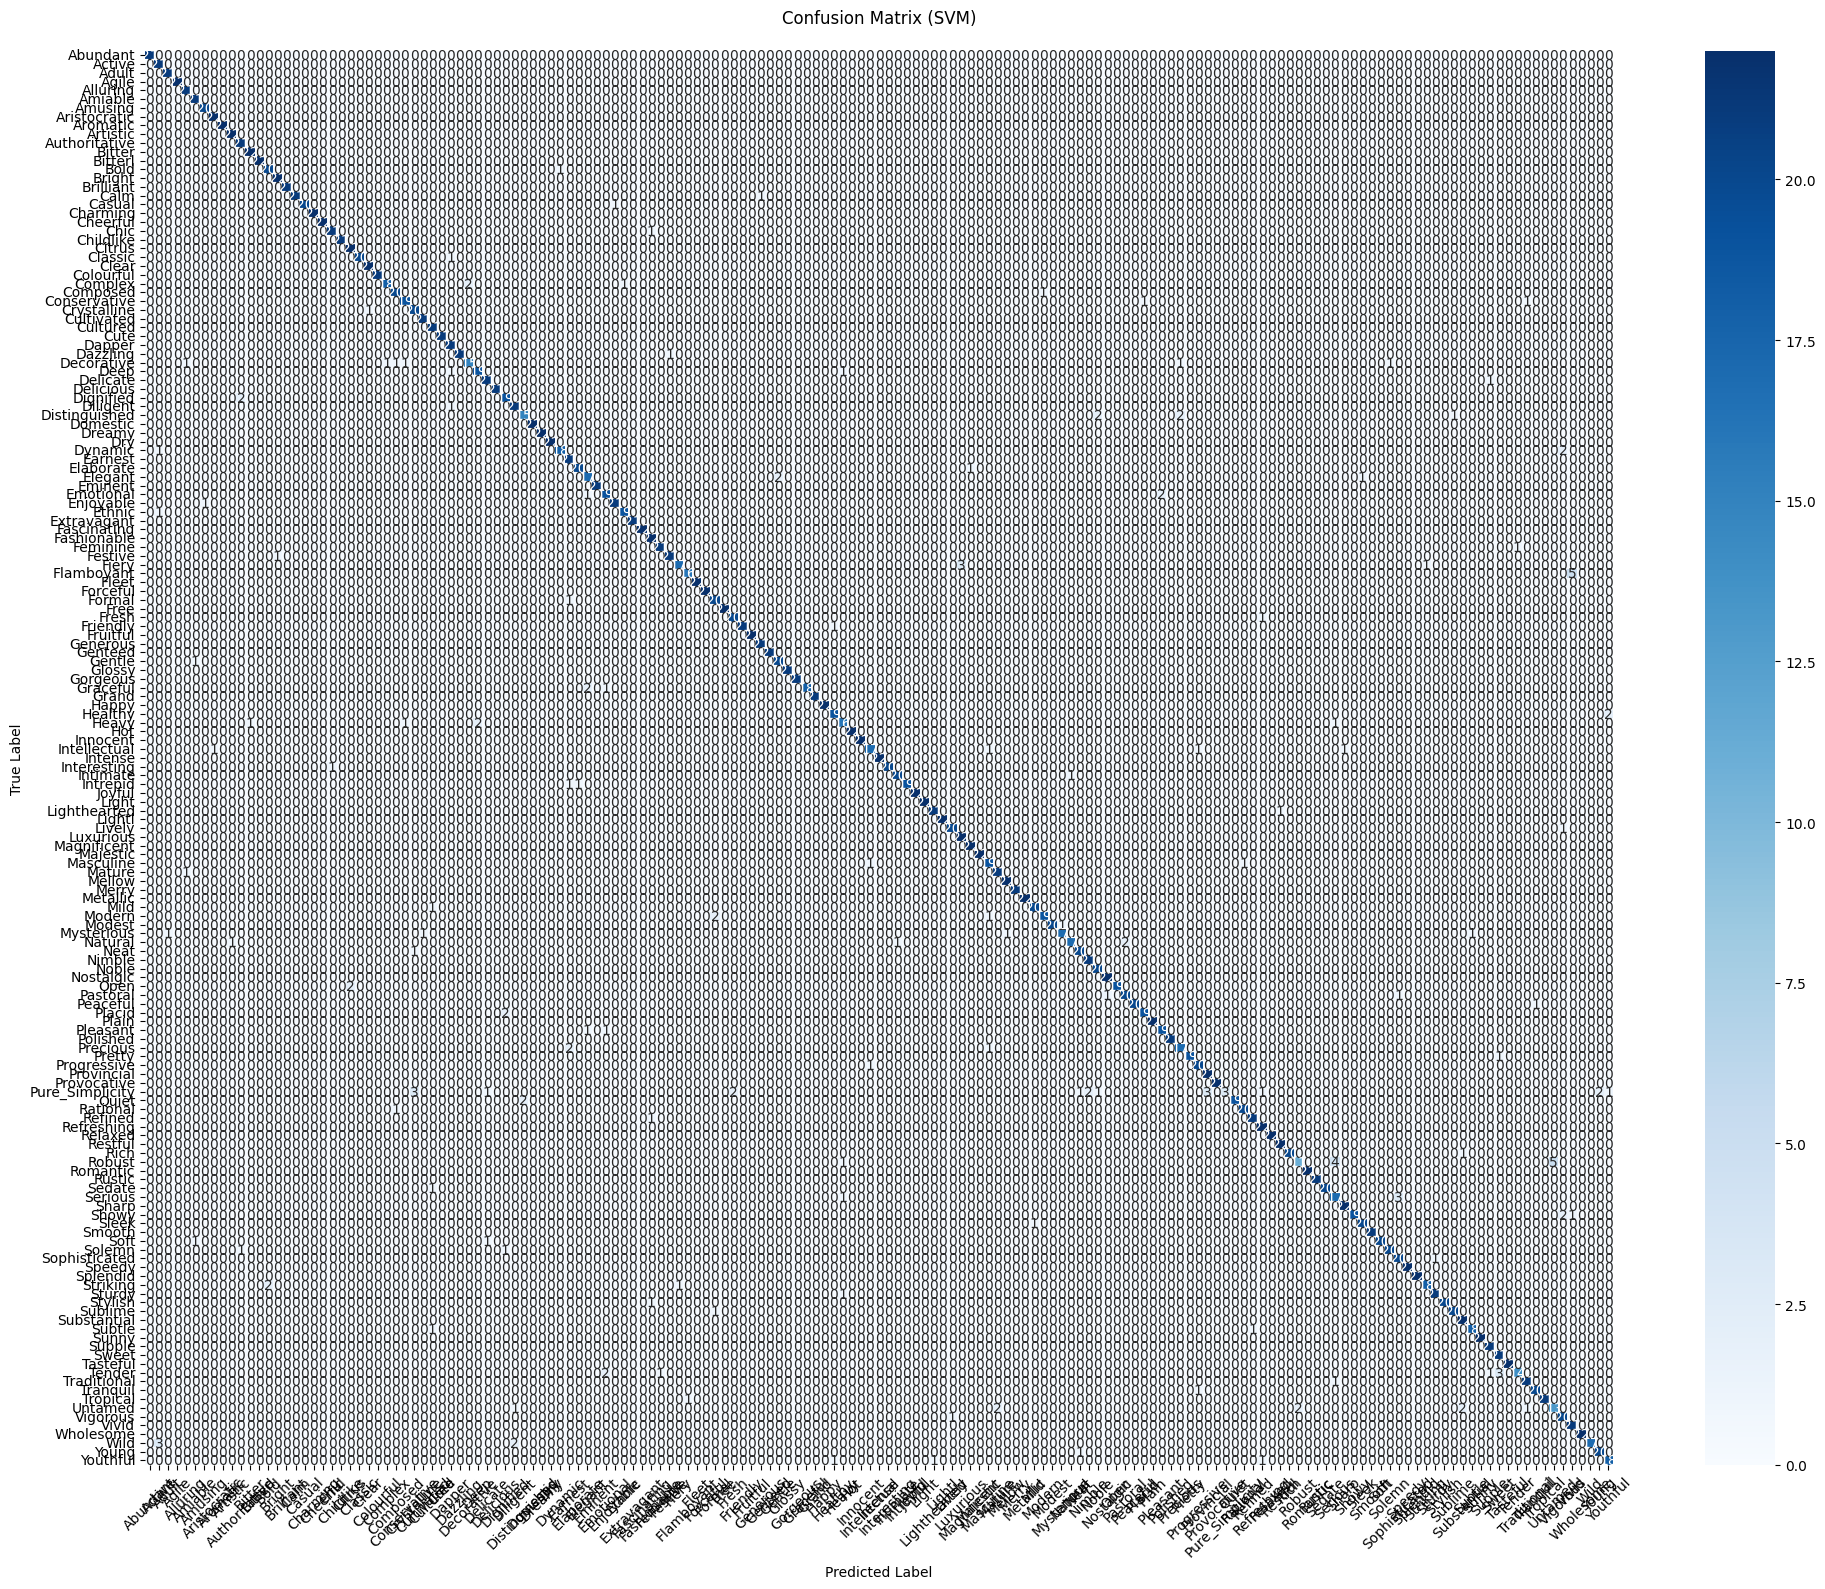

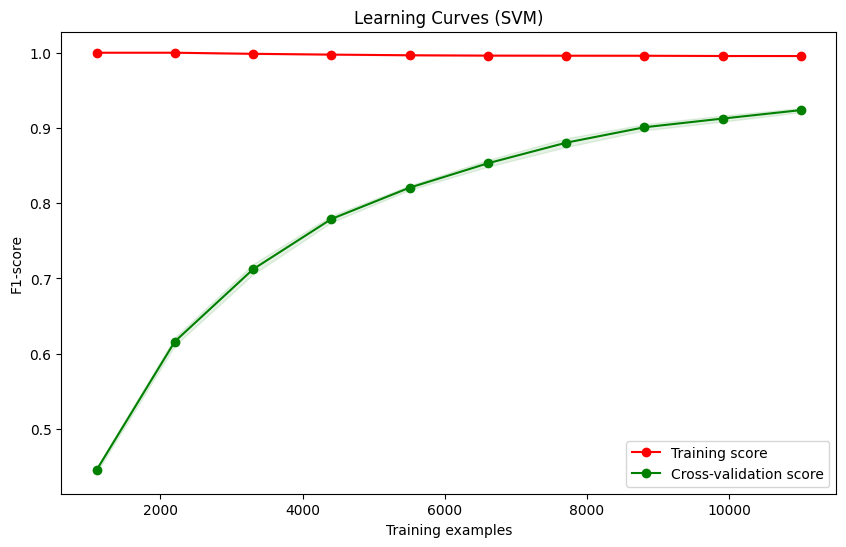

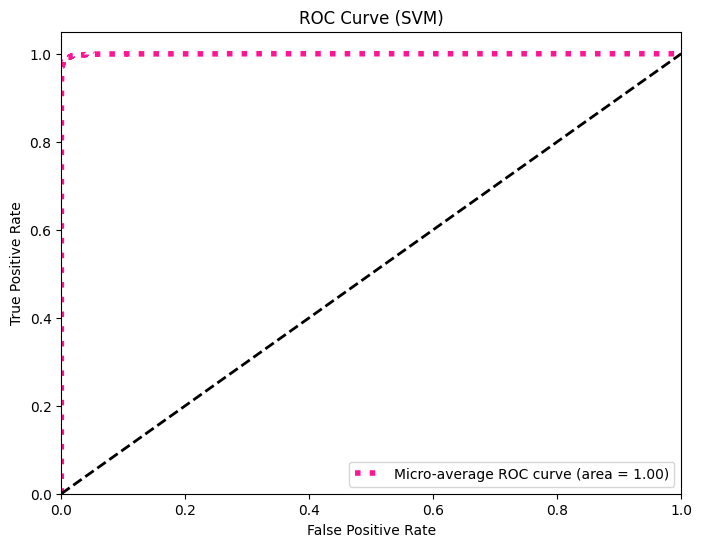

Model saved successfully to ../emotion-predictor/backend/app/model\svm_model.pkl


In [ ]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and preprocess data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Normalize input features to [0, 1] range
y = data.iloc[:, -1].values

# 3. Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Create a pipeline with the best hyperparameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=100, kernel='poly', degree=4, gamma=0.1, coef0=1.0, probability=True, random_state=42))
])

# 6. Set up Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 7. Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')

# Print cross-validation results
print("\nStratified K-Fold Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# 8. Fit the model on the entire training set
best_model.fit(X_train, y_train)

# 9. Evaluate the final model on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Test Metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

# Train Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)

print("\nFinal Model Results on Test Set:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, 
            annot=True,        
            fmt='d',           
            cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix (SVM)', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 11. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=skf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves (SVM)")
plt.legend(loc="best")
plt.show()

# 12. ROC Curve
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]
y_score = best_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

# 13. Save the model and scaler
model_dir = '../emotion-predictor/backend/app/model'
os.makedirs(model_dir, exist_ok=True)

# Save the model using pickle
model_path = os.path.join(model_dir, 'svm_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model saved successfully to {model_path}")

# Save the label encoder
le_path = os.path.join(model_dir, 'label_encoder.pkl')
with open(le_path, 'wb') as f:     
    pickle.dump(le, f)



Stratified K-Fold Cross-Validation Results:
CV Scores: [0.92989466 0.92953142 0.92262986 0.92732558 0.92332849]
Mean CV Score: 0.9265
Standard Deviation of CV Scores: 0.0030

Final Model Results on Test Set:
Test Accuracy: 0.9448
Test Precision: 0.9470
Test Recall: 0.9448
Test F1-score: 0.9424
Train Accuracy: 0.9955

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.81      1.00      0.89        21
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        22
           4       0.91      1.00      0.95        21
           5       0.91      1.00      0.95        21
           6       0.95      1.00      0.98        20
           7       0.96      1.00      0.98        22
           8       1.00      1.00      1.00        22
           9       0.96      1.00      0.98        22
          10       0.88      1.00      0.93        

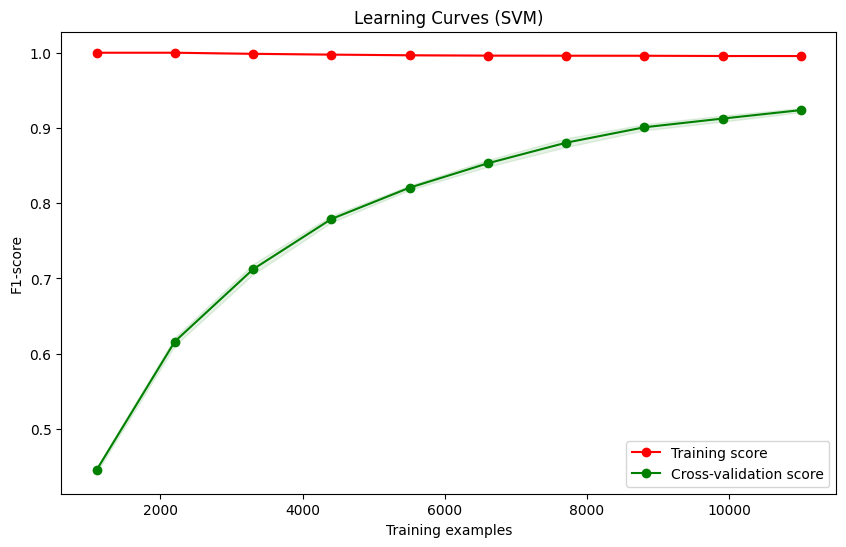


Prediction for new sample:
Provincial: 16.11%
Quiet: 5.47%


In [1]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and preprocess data
data = pd.read_csv('final_dataset.csv')
# Normalize input features to [0, 1] range
X = data.iloc[:, :-1].values / 255.0  
y = data.iloc[:, -1].values

# 3. Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 5. Create a pipeline with the best hyperparameters
# (Note: the pipeline includes a scaler, similar to the FastAPI approach for SVM)
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=100, kernel='poly', degree=4, gamma=0.1, coef0=1.0,
                probability=True, random_state=42))
])

# 6. Set up Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 7. Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')

# Print cross-validation results
print("\nStratified K-Fold Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")

# 8. Fit the model on the entire training set
best_model.fit(X_train, y_train)

# 9. Evaluate the final model on the test set and train set
y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
train_accuracy = accuracy_score(y_train, y_pred_train)

print("\nFinal Model Results on Test Set:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

# 10. Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=skf, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves (SVM)")
plt.legend(loc="best")
plt.show()

# 11. New Sample Prediction
# Define a new sample's RGB values for the three regions (total 9 values):
# Example new sample: 
# RGB1: (200, 201, 218), RGB2: (138, 130, 101), RGB3: (55, 61, 37)
new_sample_raw = np.array([[200, 201, 218, 138, 130, 101, 55, 61, 37]])

# IMPORTANT: Normalize the new sample in the same way as training data (divide by 255)
new_sample = new_sample_raw / 255.0

# Obtain probability predictions for the new sample using the pipeline’s predict_proba
probs = best_model.predict_proba(new_sample)

# Get the indices of the top two predictions (sorted in descending order)
top_two_indices = np.argsort(probs[0])[::-1][:2]

# Convert these indices back to the original emotion labels using the label encoder
top_two_emotions = le.inverse_transform(top_two_indices)

print("\nPrediction for new sample:")
for idx in top_two_indices:
    probability_percent = probs[0][idx] * 100
    print(f"{le.inverse_transform([idx])[0]}: {probability_percent:.2f}%")


### **Conclusion & Final Thoughts**

- The **SVM model proved highly effective** for multi-class classification of **emotion-related words** based on **RGB color data**.
- The **high accuracy across various evaluation metrics** and the **strong AUC score** confirm the model’s robustness.
- Some **indications of overfitting** were detected, but they **do not significantly impact real-world performance**.
- The success of this **SVM model reinforces the power of Support Vector Machines** for **multi-class classification problems**, especially when **hyperparameters are well-optimized**.
- Overall, the model is **suitable for practical applications**, delivering **high accuracy and reliable results**.

🚀 **Final Verdict:** The SVM model is a **powerful and reliable classifier** for this task, demonstrating **high accuracy and strong generalization performance**! ✅
